<a href="https://colab.research.google.com/github/Eshan133/CIFAR10/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Packages

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

----
# 2. Importing the dataset **(CIFAR10)**

In [ ]:
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              download=True,
                              transform=ToTensor(),
                              target_transform=None)

In [ ]:
test_data = datasets.CIFAR10(root="data",
                              train=False,
                              download=True,
                              transform=ToTensor(),
                              target_transform=None)

---
# 3. Dataset Visualization

In [ ]:
train_data, test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")

Length of train dataset: 50000
Length of test dataset: 10000


In [ ]:
img, label = train_data[0]
class_names = train_data.classes

print(f"Classes present in the dataset: {class_names}")

Classes present in the dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3.1 Visualizing a image from the dataset

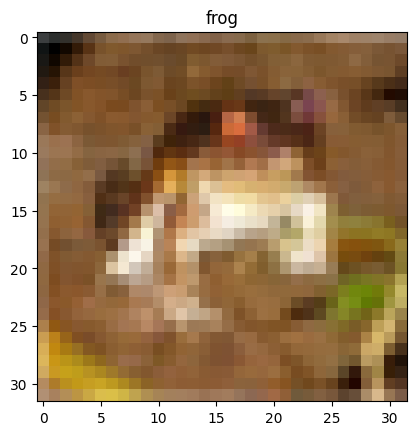

In [ ]:
plt.imshow(img.permute(1,2,0).numpy())
plt.title(class_names[label])
plt.show()

## 3.2 Visualizing and comparing **[color channel, height, weight]**

In [ ]:
print(f"Image Shape: {img.shape} --> [color channel, height, weight]")

Image Shape: torch.Size([3, 32, 32]) --> [color channel, height, weight]


In [ ]:
color_channel = []
height = []
width = []

for img, _ in train_data:
  c, h, w = img.shape
  color_channel.append(c)
  height.append(h)
  width.append(w)

In [ ]:
import numpy as np

In [ ]:
color_channel = np.array(color_channel)
height = np.array(height)
width = np.array(width)

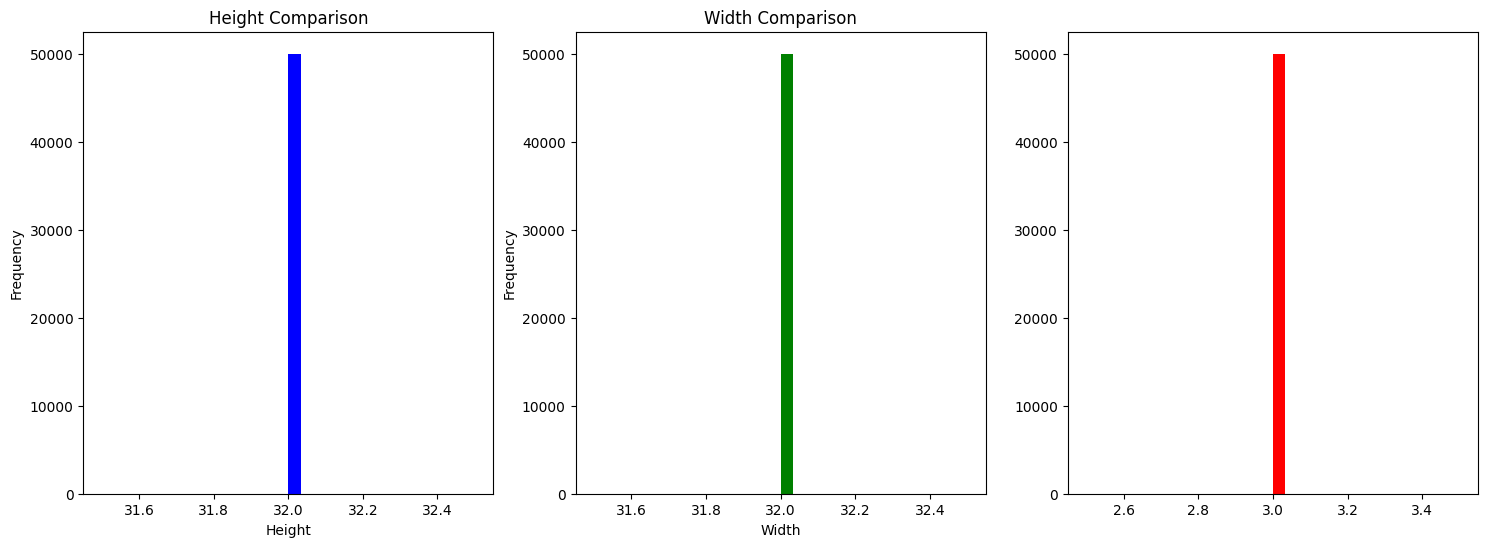

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].hist(height, color="blue", bins=30)
axs[0].set_title("Height Comparison")
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Height")

axs[1].hist(height, color="green", bins=30)
axs[1].set_title("Width Comparison")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Width")

axs[2].hist(color_channel, color="red", bins=30)

plt.show()

## 3.3 Visualizing the images present in the dataset

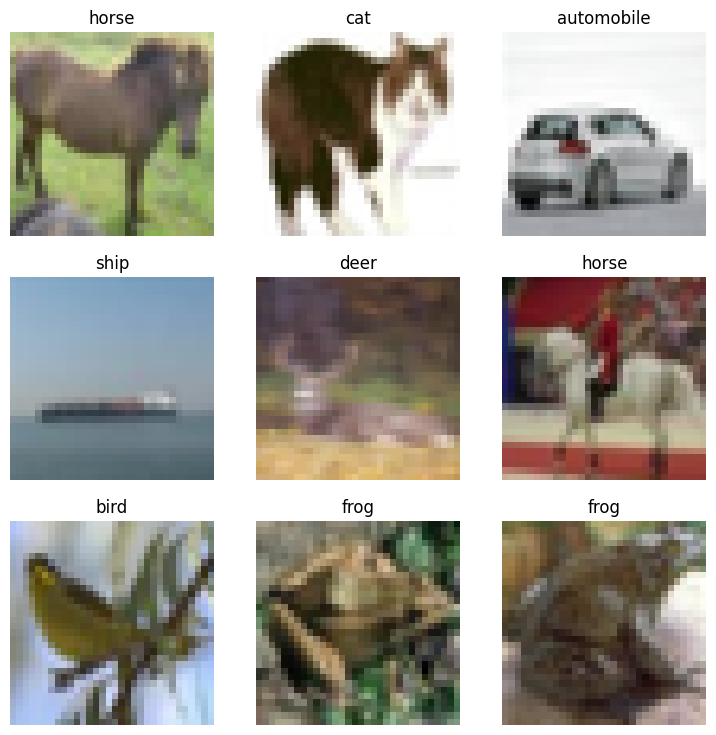

In [ ]:
fig = plt.figure(figsize=(9,9))
rows = 3
cols = 3

for i in range(1, rows*cols+1):
  rand_idx = torch.randint(1, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0).numpy())
  plt.title(class_names[label])
  plt.axis(False)

---
# 4. Preparing the DataLoader

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 4.1 Visualizing the DataLoader

In [ ]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x797efbcb2090>,
 <torch.utils.data.dataloader.DataLoader at 0x797efbbf9150>)

In [ ]:
print(f"Length of train data: {len(train_data)}")
print(f"Length of test data: {len(test_data)}")
print('--------------------------------------------------------')
print(f"Length of train dataloader: {len(train_dataloader)} of size {BATCH_SIZE}...")
print(f"Length of test dataloader: {len(test_dataloader)} of size {BATCH_SIZE}...")

Length of train data: 50000
Length of test data: 10000
--------------------------------------------------------
Length of train dataloader: 1563 of size 32...
Length of test dataloader: 313 of size 32...


## 4.2 Extracting data from the dataloader **(CHECKING)**

In [ ]:
# For train dataloader
train_feature, train_labels = next(iter(train_dataloader))

In [ ]:
print("FOR EACH ITERATION")
print("-------------------------------")
print(f"Shape of train features [INPUT]: {train_feature.shape}")
print(f"Shape of train labels [OUTPUT]: {train_labels.shape}")

FOR EACH ITERATION
-------------------------------
Shape of train features [INPUT]: torch.Size([32, 3, 32, 32])
Shape of train labels [OUTPUT]: torch.Size([32])


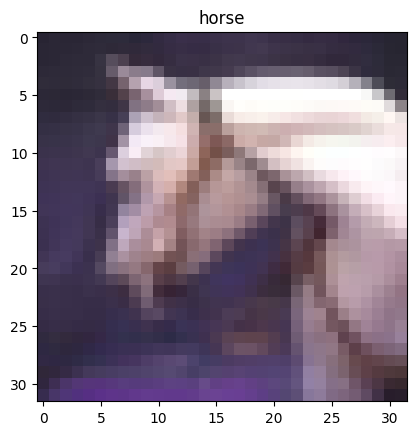

In [ ]:
# First data from one iteration of train_dataloader
plt.imshow(train_feature[0].permute(1,2,0))
plt.title(class_names[train_labels[0]])
plt.show()

---
# 5. Training and Testing loop

### 5.1 training_loop()

In [ ]:
def training_loop(model:torch.nn.Module,
                  dataloader:torch.utils.data.DataLoader,
                  loss_fn:torch.nn.Module,
                  optimizer:torch.optim.Optimizer,
                  accuracy_fn,
                  device:torch.device=device):

  model.train()
  model.to(device)
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Froward Pass
    y_pred = model(X)

    # Calculate Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Calculate Accuracy
    acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
    train_acc += acc

    # Optimizer Zero Grad
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer Step
    optimizer.step()

    # Print the no. of Batch completed
    if(batch % 200 == 0):
      print(f"{batch} BATCH HAS BEEN COMPLETED..")

  train_acc /= len(dataloader)
  train_loss /= len(dataloader)

  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")

  return train_acc, train_loss



### 5.2 testing_loop()

In [ ]:
def testing_loop(model:torch.nn.Module,
                 dataloader:torch.utils.data.DataLoader,
                 loss_fn:torch.nn.Module,
                 accuracy_fn,
                 device:torch.device=device):

  model.eval()
  model.to(device)

  with torch.inference_mode():
    test_acc, test_loss = 0, 0

    for X,y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
      test_acc += acc

    test_acc /= len(dataloader)
    test_loss /= len(dataloader)

    print(f"Test Loss: {test_loss:.5f} || Test Accuracy: {test_acc:.2f}%")

    return test_acc, test_loss


---
# 6. Evaluation & Prediction Function

### 6.1 evaluation()

In [ ]:
def evaluation(model:torch.nn.Module,
               train_acc,
                train_loss,
                test_acc,
                test_loss,
                epochs:int,
                learning_rate:float,
                optimizer_name,
                time_taken,
                device:torch.device = device):

  return {
      'model_name': model.__class__.__name__,
      'learning_rate':learning_rate,
      'epochs':epochs,
      'optimizer':optimizer_name,
      'train_loss': train_loss.item(),
      'train_accuracy':train_acc,
      'test_loss': test_loss.item(),
      'test_accuracy':test_acc,
      'time_taken':time_taken,
      'device':device
  }

### 6.2 plot_metrics()

In [ ]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Create subplots
    fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss
    ax1[0].plot(epochs, train_losses, label="Train Loss", marker='o')
    ax1[0].plot(epochs, test_losses, label="Test Loss", marker='o')
    ax1[0].set_xlabel("Epochs")
    ax1[0].set_ylabel("Loss")
    ax1[0].set_title("Training and Testing Loss")
    ax1[0].legend()

    # Plot Accuracy
    ax1[1].plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
    ax1[1].plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
    ax1[1].set_xlabel("Epochs")
    ax1[1].set_ylabel("Accuracy")
    ax1[1].set_title("Training and Testing Accuracy")
    ax1[1].legend()

    plt.show()

### 6.2 make_predictions()

In [ ]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device=device):

  pred_probs = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

---
# 7. Setting up Loss & Accuracy Function

In [ ]:
import requests
from pathlib import Path

# Download helper function
if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping download>>")
else:
  print("Downloading helper_function.py>>>>>>>>")
  request = requests.get("https://raw.githubusercontent.com/Eshan133/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)
    print("Downloading complete")

helper_function.py already exists, skipping download>>


In [ ]:
# import the accuracy metircs from helper_function.py
from helper_function import accuracy_fn

#setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()

---
# 8. Timer Function

In [ ]:
from timeit import default_timer as timer

def print_time(start:float, end:float, device:torch.device=None):
  total_time = end - start
  print(f"Total time taken on {device}: {total_time:.3f} seconds")
  return total_time

---
# 9. Base Model

In [ ]:
# Tiny VGG net
class ModelV1(nn.Module):
  def __init__(self,
               input_units:int,
               hidden_units:int,
               output_units:int):
    super().__init__()

    ## Feature Extraction Layers
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    ## Classifier/Output layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8,
                  out_features=output_units),
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)

    x = self.conv_block_2(x)
    # print(x.shape)

    x = self.classifier(x)
    # print(x.shape)

    return x

## 9.1 Initializing the base model

In [ ]:
modelV1 = ModelV1(input_units=3,
                  hidden_units=10,
                  output_units=len(class_names)).to(device)

## 9.2 Setting up Optimizer of base model

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=learning_rate)

----
## 9.3 Finding the shape of Linear Layer


Here, we need to keep one thing in mind:
- Linear Layer, takes input shape that doesn't match the hidden unit. `i.e` the output of `conv_block_2`.
- Hence, we need to create a dummy data of same shape as the input, and print the shape after each layer to identify the correct shape.
- Let's do that now....
  - Shape of output of `conv_block_2`: torch.Size([1, 10, 8, 8])
  - So, let's multiply the `in_features` by $8*8$

In [ ]:
dummy_data = torch.rand(size = (3, 32, 32))

modelV1(dummy_data.unsqueeze(0).to(device))

tensor([[ 0.0083,  0.0020, -0.0486,  0.0066,  0.0091, -0.0375, -0.0117, -0.0250,
         -0.0079, -0.0330]], device='cuda:0', grad_fn=<AddmmBackward0>)

----
## 9.4 Training the Base Model

In [ ]:
from tqdm.auto import tqdm

  0%|          | 0/5 [00:00<?, ?it/s]

--- Epoch: 0 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.91198 | Train Accuracy: 30.25%
Test Loss: 1.53823 || Test Accuracy: 44.25%
-------------------------------
--- Epoch: 1 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.43640 | Train Accuracy: 48.93%
Test Loss: 1.39149 || Test Accuracy: 51.87%
-------------------------------
--- Epoch: 2 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMP

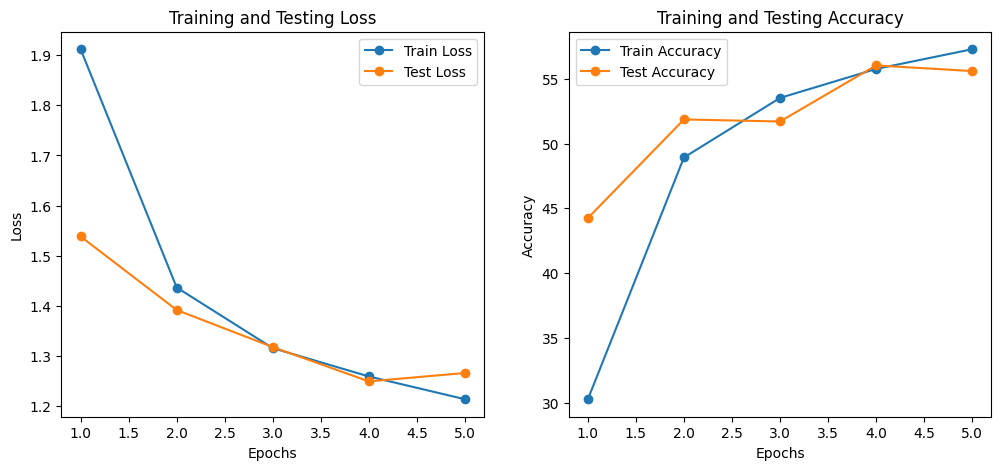

Total time taken on cuda: 58.736 seconds


In [ ]:
epochs = 5

start_time_1 = timer()
train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(epochs)):
  print(f"--- Epoch: {epoch} ---")
  train_acc, train_loss = training_loop(model=modelV1,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        optimizer=optimizer,
                                        device=device)

  test_acc, test_loss = testing_loop(model=modelV1,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device)
  print("-------------------------------")

  # Store metrics
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

end_timer_1 = timer()

# Plot the metrics
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

total_time_model_V1 = print_time(start=start_time_1, end=end_timer_1, device=device)

## 9.5 Evaluating the Base Model

In [ ]:
eval_model_V1 = evaluation(model=modelV1,
                           train_acc=train_acc,
                           train_loss=train_loss,
                           test_acc=test_acc,
                           test_loss=test_loss,
                            epochs=epochs,
                            learning_rate=learning_rate,
                            optimizer_name='SGD',
                            time_taken=total_time_model_V1,
                            device=device)

In [ ]:
eval_model_V1

{'model_name': 'ModelV1',
 'learning_rate': 0.1,
 'epochs': 5,
 'optimizer': 'SGD',
 'train_loss': 1.213430643081665,
 'train_accuracy': 57.28966730646193,
 'test_loss': 1.2657772302627563,
 'test_accuracy': 55.60103833865815,
 'time_taken': 58.73629122499983,
 'device': 'cuda'}

---
# 10. Hyperparameter Tuning

## 10.1 Increasing epochs

In [ ]:
modelV1_1 = ModelV1(input_units=3,
                  hidden_units=10,
                  output_units=len(class_names)).to(device)

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.SGD(params=modelV1_1.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

--- Epoch: 0 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 2.28821 | Train Accuracy: 11.95%
Test Loss: 2.20201 || Test Accuracy: 20.87%
-------------------------------
--- Epoch: 1 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.80082 | Train Accuracy: 35.98%
Test Loss: 1.51407 || Test Accuracy: 45.48%
-------------------------------
--- Epoch: 2 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMP

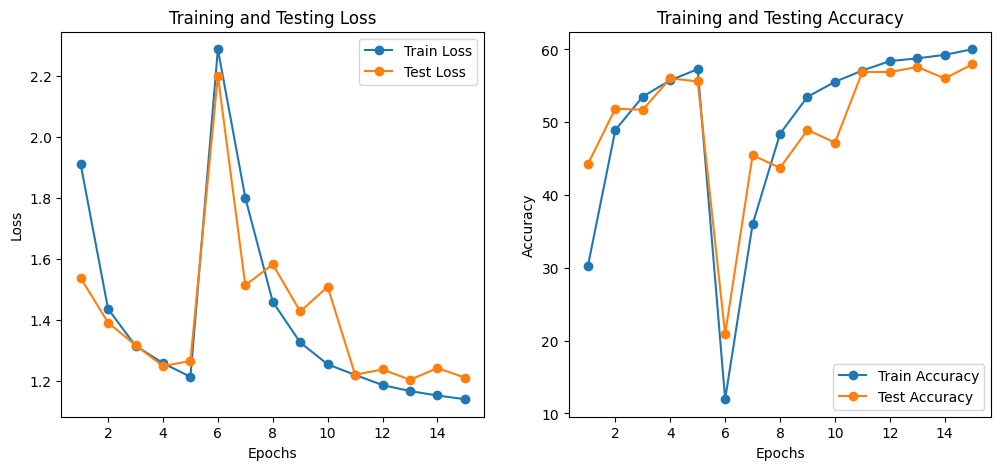

Total time taken on cuda: 117.528 seconds


In [ ]:
epochs = 10

start_time_1 = timer()

for epoch in tqdm(range(epochs)):
  print(f"--- Epoch: {epoch} ---")
  train_acc, train_loss = training_loop(model=modelV1_1,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                optimizer=optimizer,
                device=device)

  test_acc, test_loss = testing_loop(model=modelV1_1,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
  print("-------------------------------")

  # Store metrics
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

end_timer_1 = timer()

# Plot the metrics
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

total_time_model_V1 = print_time(start=start_time_1, end=end_timer_1, device=device)

In [ ]:
eval_model_V1_1 = evaluation(model=modelV1_1,
                             train_acc=train_acc,
                              train_loss=train_loss,
                              test_acc=test_acc,
                              test_loss=test_loss,
                              epochs=epochs,
                              learning_rate=learning_rate,
                              optimizer_name='SGD',
                              time_taken=total_time_model_V1,
                              device=device)

In [ ]:
eval_model_V1_1

{'model_name': 'ModelV1',
 'learning_rate': 0.1,
 'epochs': 10,
 'optimizer': 'SGD',
 'train_loss': 1.1402863264083862,
 'train_accuracy': 60.03079014715291,
 'test_loss': 1.2111352682113647,
 'test_accuracy': 57.947284345047926,
 'time_taken': 117.52786725700003,
 'device': 'cuda'}

train_loss, test_loss, comments

In [ ]:
import pandas as pd

In [ ]:
comparision_df = pd.DataFrame([eval_model_V1,eval_model_V1_1])
comparision_df['comment'] = ['Let\'s try increasing the epoch',
                             'Increasing epoch is still giving better results, Also the jump is crazy']

In [ ]:
comparision_df

,model_name,learning_rate,epochs,optimizer,train_loss,train_accuracy,test_loss,test_accuracy,time_taken,device,comment
0,ModelV1,0.1,5,SGD,1.213431,57.289667,1.265777,55.601038,58.736291,cuda,Let's try increasing the epoch
1,ModelV1,0.1,10,SGD,1.140286,60.030790,1.211135,57.947284,117.527867,cuda,Increasing epoch is still giving better result...


----

  0%|          | 0/20 [00:00<?, ?it/s]

--- Epoch: 0 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.95758 | Train Accuracy: 28.17%
Test Loss: 1.72605 || Test Accuracy: 38.81%
-------------------------------
--- Epoch: 1 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.45675 | Train Accuracy: 47.94%
Test Loss: 1.40125 || Test Accuracy: 49.61%
-------------------------------
--- Epoch: 2 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMP

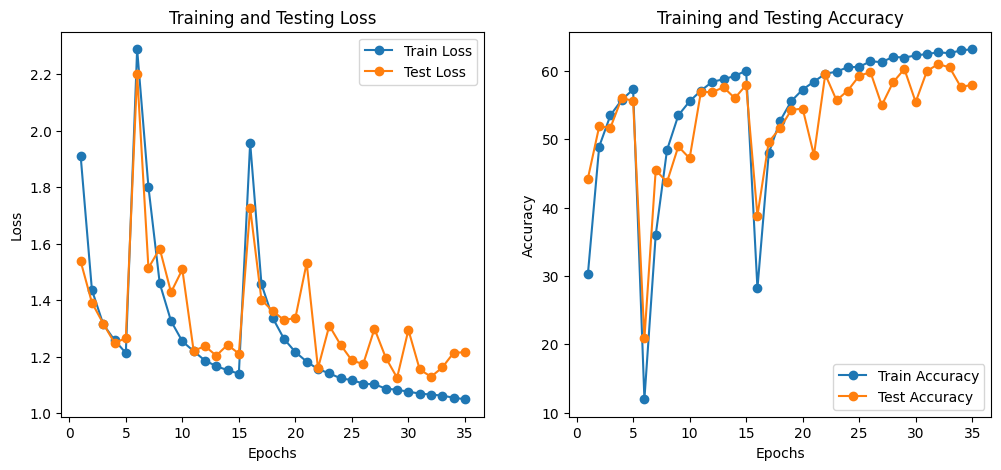

Total time taken on cuda: 237.083 seconds


In [ ]:
# Epoch: 20

modelV1_2 = ModelV1(input_units=3,
                  hidden_units=10,
                  output_units=len(class_names)).to(device)

learning_rate = 0.1
optimizer = torch.optim.SGD(params=modelV1_2.parameters(), lr=learning_rate)

epochs = 20

start_time_1 = timer()

for epoch in tqdm(range(epochs)):
  print(f"--- Epoch: {epoch} ---")
  train_acc, train_loss = training_loop(model=modelV1_2,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                optimizer=optimizer,
                device=device)

  test_acc, test_loss = testing_loop(model=modelV1_2,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
  print("-------------------------------")

  # Store metrics
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)


end_timer_1 = timer()

# Plot the metrics
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

total_time_model_V1 = print_time(start=start_time_1, end=end_timer_1, device=device)

In [ ]:
eval_model_V1_2 = evaluation(model=modelV1_2,
                             train_acc=train_acc,
                              train_loss=train_loss,
                              test_acc=test_acc,
                              test_loss=test_loss,
                              epochs=epochs,
                              learning_rate=learning_rate,
                              optimizer_name='SGD',
                              time_taken=total_time_model_V1,
                              device=device)

In [ ]:
comparision_df = pd.DataFrame([eval_model_V1,eval_model_V1_1, eval_model_V1_2])
comparision_df['comment'] = ['Let\'s try increasing the epoch',
                             'Increasing epoch is still giving better results',
                             'Shows sign of overfitting & jumps crazy']

In [ ]:
comparision_df

,model_name,learning_rate,epochs,optimizer,train_loss,train_accuracy,test_loss,test_accuracy,time_taken,device,comment
0,ModelV1,0.1,5,SGD,1.213431,57.289667,1.265777,55.601038,58.736291,cuda,Let's try increasing the epoch
1,ModelV1,0.1,10,SGD,1.140286,60.030790,1.211135,57.947284,117.527867,cuda,Increasing epoch is still giving better results
2,ModelV1,0.1,20,SGD,1.049841,63.169786,1.216180,57.977236,237.083454,cuda,Shows sign of overfitting & jumps crazy


## 10.2 Data Augmentation

In [ ]:
import torchvision.transforms as transforms

# Define Data Augmentation for Training Set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])


# Test Transform (No Augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Load the dataset with augmentation for training set
train_dataset = datasets.CIFAR10(root="data", train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root="data", train=False, transform=test_transform, download=True)

# Create DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
len(train_dataloader)

1563

  0%|          | 0/20 [00:00<?, ?it/s]

--- Epoch: 0 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.91962 | Train Accuracy: 29.30%
Test Loss: 1.64972 || Test Accuracy: 40.55%
-------------------------------
--- Epoch: 1 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMPLETED..
1400 BATCH HAS BEEN COMPLETED..
Train Loss: 1.67793 | Train Accuracy: 38.90%
Test Loss: 1.72909 || Test Accuracy: 40.32%
-------------------------------
--- Epoch: 2 ---
0 BATCH HAS BEEN COMPLETED..
200 BATCH HAS BEEN COMPLETED..
400 BATCH HAS BEEN COMPLETED..
600 BATCH HAS BEEN COMPLETED..
800 BATCH HAS BEEN COMPLETED..
1000 BATCH HAS BEEN COMPLETED..
1200 BATCH HAS BEEN COMP

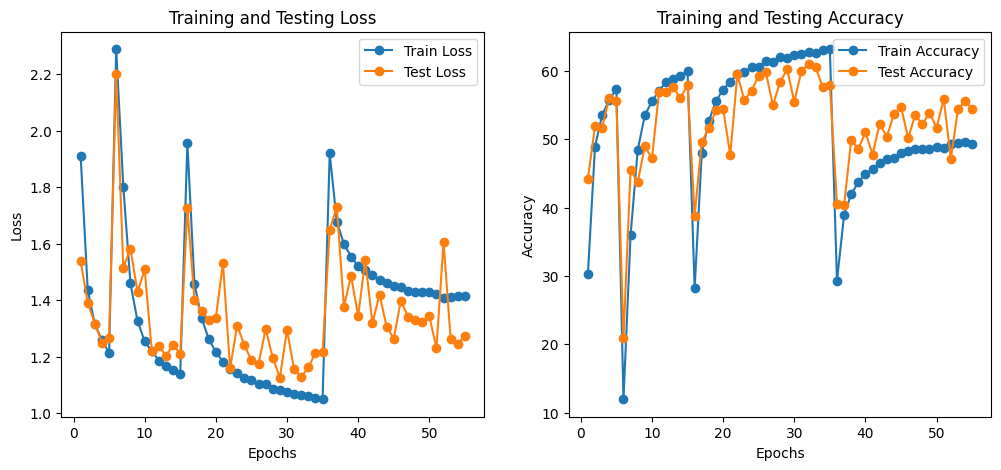

Total time taken on cuda: 1059.631 seconds


In [ ]:
# Epoch: 20

modelV1_3 = ModelV1(input_units=3,
                  hidden_units=10,
                  output_units=len(class_names)).to(device)

learning_rate = 0.1
optimizer = torch.optim.SGD(params=modelV1_3.parameters(), lr=learning_rate)

epochs = 9

start_time_1 = timer()

for epoch in tqdm(range(epochs)):
  print(f"--- Epoch: {epoch} ---")
  train_acc, train_loss = training_loop(model=modelV1_3,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                optimizer=optimizer,
                device=device)

  test_acc, test_loss = testing_loop(model=modelV1_3,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
  print("-------------------------------")

  # Store metrics
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)


end_timer_1 = timer()

# Plot the metrics
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

total_time_model_V1 = print_time(start=start_time_1, end=end_timer_1, device=device)

In [ ]:
eval_model_V1_3 = evaluation(model=modelV1_3,
                             train_acc=train_acc,
                              train_loss=train_loss,
                              test_acc=test_acc,
                              test_loss=test_loss,
                              epochs=epochs,
                              learning_rate=learning_rate,
                              optimizer_name='SGD',
                              time_taken=total_time_model_V1,
                              device=device)

### **Different Architectures:**

- **ResNet:** A deeper but efficient model that often generalizes well.
- **MobileNet:** A lightweight model that works well on CIFAR-10 with good accuracy.
- **EfficientNet:** Scales well and has strong generalization capabilities

In [ ]:
# VGG19

class ModelV2(nn.Module):
  def __init__(self,
               input_units,
               hidden_units,
               output_units):
     super().__init__()

     self.conv_block_1 = nn.Sequential(
         nn.Conv2d(in_channels=input_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),

     )



